# Learning Laplacian eigenfunctions in three dimensions

In [1]:
# Load libraries
import logging

import matplotlib.pyplot as plt
import numpy as np

from klap import (
    ExponentialKernel,
    GaussianKernel,
    PolynomialKernel,
)
from klap.datasets.helper import (
    meshgrid_3d,
    plot_sphere_surface,
    spherical_harmonic,
)

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{mathtools}")
plt.rc("font", size=10, family="serif", serif="cm")
plt.rc("figure", figsize=(2, 1.5))

# Set logger
logging.basicConfig(
    level=logging.ERROR,
    format="%(asctime)s %(levelname)s %(message)s",
)

#### Generate data 

In [2]:
np.random.seed(100)
n = 10000
p = 500

# Learn spherical harmonics
x = np.random.randn(n, 3)
x /= np.sqrt(np.sum(x**2, axis=1))[:, np.newaxis]
X, Y, Z = meshgrid_3d(100)

#### Choose a kernel and method

In [3]:
kernel = PolynomialKernel(d=3)
# kernel = ExponentialKernel(sigma=10)
# kernel = GaussianKernel(sigma=3)

graph_laplacian = False

#### Fit eigenfunctions

In [4]:
help(kernel.fit)

Help on method fit in module klap.kernels.kernel_laplacian:

fit(x, p=None, k=None, L_reg: float = 0, R_reg: float = 0, inverse_L: bool = False) method of klap.kernels.polynomial.PolynomialKernel instance
    Estimate Laplacian operator based on data.
    
    Parameters
    ----------
    x: ndarray of size (n, d)
        Data matrix
    p: int (optional, default is None)
        Number of representer points to use
    k: int (optional, default is None)
        Number of eigenvalues to compute. If None, k will be taken as self.k (default is 16)
    L_reg: float (optional, default is 0)
        Regularization parameter for Laplacian matrix
    R_reg: float (optional, default is 0)
        Regularization parameter for Nystrom matrix
    inverse_L: bool (optional, default is False)
        Either to inverse L or R in the GEVD system.



In [5]:
k = 25
L_reg = 0
R_reg = 0
inverse_L = True

if graph_laplacian:
    weigth_kernel = GaussianKernel(sigma=1).kernel
    kernel.fit_with_graph_laplacian(weigth_kernel, x, p=p, k=k, L_reg=L_reg, R_reg=R_reg, inverse_L=inverse_L)
else:
    kernel.fit(x, p=p, k=k, L_reg=L_reg, R_reg=R_reg, inverse_L=inverse_L)

2023-05-05 20:41:46,951 INFO Dot product kernel computation
2023-05-05 20:41:47,245 INFO Matrix is not sdp.
2023-05-05 20:41:47,246 INFO Setting regularizer to 6.885e-12


#### Get eigenfunctions / features map

In [6]:
x_test = np.stack((X.flatten(), Y.flatten(), Z.flatten()), axis=-1)
phi = kernel(x_test)

#### Plot eigenfunctions

In [7]:
num = 5
phi /= np.sqrt(np.mean(phi**2, axis=0))
phi_true, eigenvalues = spherical_harmonic(x_test, num**2, return_eigenvalues=True)
phi_true /= np.sqrt(np.mean(phi_true**2, axis=0))

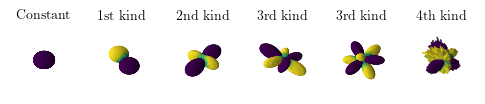

In [8]:
fig, axes = plt.subplots(1, 6, figsize=(6, 2), subplot_kw={"projection": "3d"})
j = 0
kinds = ["Constant", "1st kind", "2nd kind", "3rd kind", "3rd kind", "4th kind"]
for i in [0, 1, 7, 9, 15, 19]:
    phi_i = phi[:, i].reshape(*X.shape)
    Dx, Dy, Dz = np.abs(phi_i) * np.stack((X, Y, Z))
    plot_sphere_surface(axes[j], Dx, Dy, Dz, phi_i, alpha=.5, cmap="viridis")
    axes[j].set_title(rf"{kinds[j]}", fontsize=10)
    scale = 2
    axes[j].set_xlim([-scale, scale])
    axes[j].set_ylim([-scale, scale])
    axes[j].set_zlim([-scale, scale])
    j += 1
fig.savefig("learned_harmonics.jpg", bbox_inches="tight")

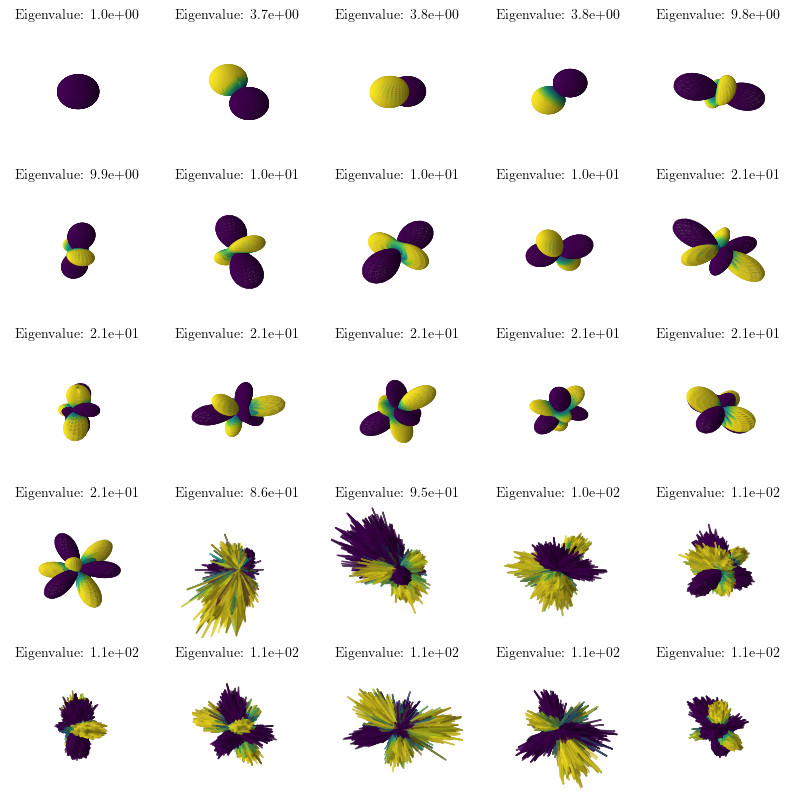

In [9]:
fig, axes = plt.subplots(num, num, figsize=(10, 10), subplot_kw={"projection": "3d"})
for i in range(num ** 2):
    phi_i = phi[:, i].reshape(*X.shape)
    Dx, Dy, Dz = np.abs(phi_i) * np.stack((X, Y, Z))
    plot_sphere_surface(axes[i//num, i%num], Dx, Dy, Dz, phi_i, alpha=.5, cmap="viridis")
    axes[i//num, i%num].set_title(f"Eigenvalue: {kernel.eigenvalues[i]:.1e}", fontsize=10)
    scale = 2
    axes[i//num, i%num].set_xlim([-scale, scale])
    axes[i//num, i%num].set_ylim([-scale, scale])
    axes[i//num, i%num].set_zlim([-scale, scale])

#### Show ground truth

Note that eigenspace linked with one eigenvalue can be parameterized by any basis, and there is no guarantee that our methods will reconstruct the spherical harmonic ones.

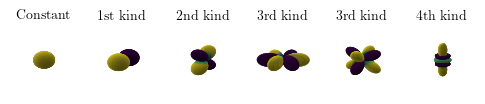

In [10]:
fig, axes = plt.subplots(1, 6, figsize=(6, 2), subplot_kw={"projection": "3d"})
j = 0
for i in [0, 1, 7, 9, 10, 20]:
    phi_i = phi_true[:, i].reshape(*X.shape)
    Dx, Dy, Dz = np.abs(phi_i) * np.stack((X, Y, Z))
    plot_sphere_surface(axes[j], Dx, Dy, Dz, phi_i, alpha=.5, cmap="viridis")
    scale = 2
    axes[j].set_title(f"{kinds[j]}", fontsize=10)
    axes[j].view_init(azim=30, elev=15)
    axes[j].set_xlim([-scale, scale])
    axes[j].set_ylim([-scale, scale])
    axes[j].set_zlim([-scale, scale])
    j += 1
fig.savefig("true_harmonics.jpg", bbox_inches="tight")

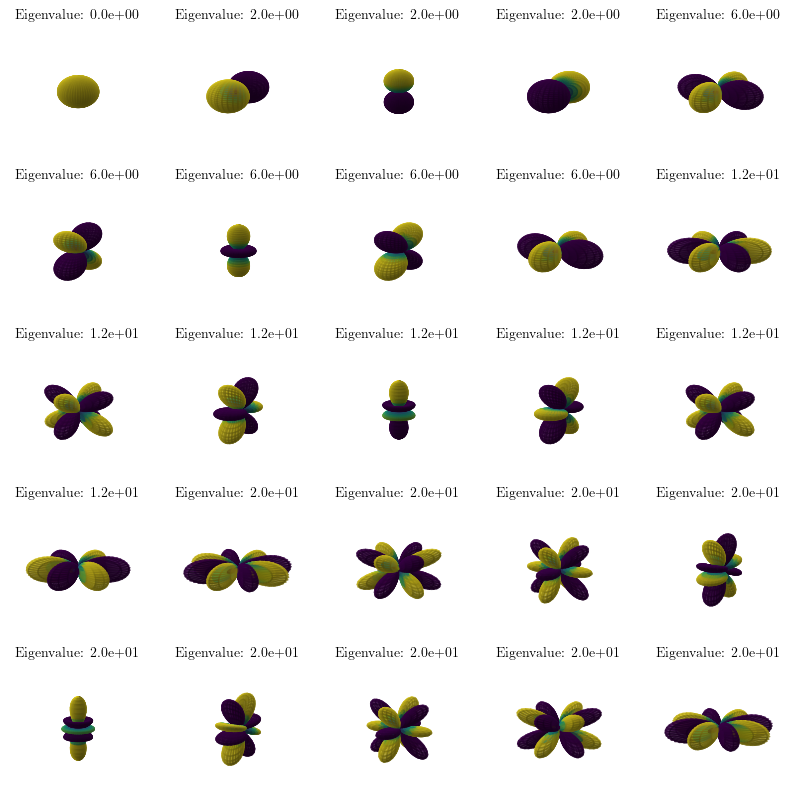

In [11]:
fig, axes = plt.subplots(num, num, figsize=(10, 10), subplot_kw={"projection": "3d"})
for i in range(num ** 2):
    phi_i = phi_true[:, i].reshape(*X.shape)
    Dx, Dy, Dz = np.abs(phi_i) * np.stack((X, Y, Z))
    plot_sphere_surface(axes[i//num, i%num], Dx, Dy, Dz, phi_i, alpha=.5, cmap="viridis")
    axes[i//num, i%num].set_title(f"Eigenvalue: {eigenvalues[i]:.1e}", fontsize=10)
    axes[i//num, i%num].view_init(azim=30, elev=15)
    scale = 2
    axes[i//num, i%num].set_xlim([-scale, scale])
    axes[i//num, i%num].set_ylim([-scale, scale])
    axes[i//num, i%num].set_zlim([-scale, scale])

#### Other visualization

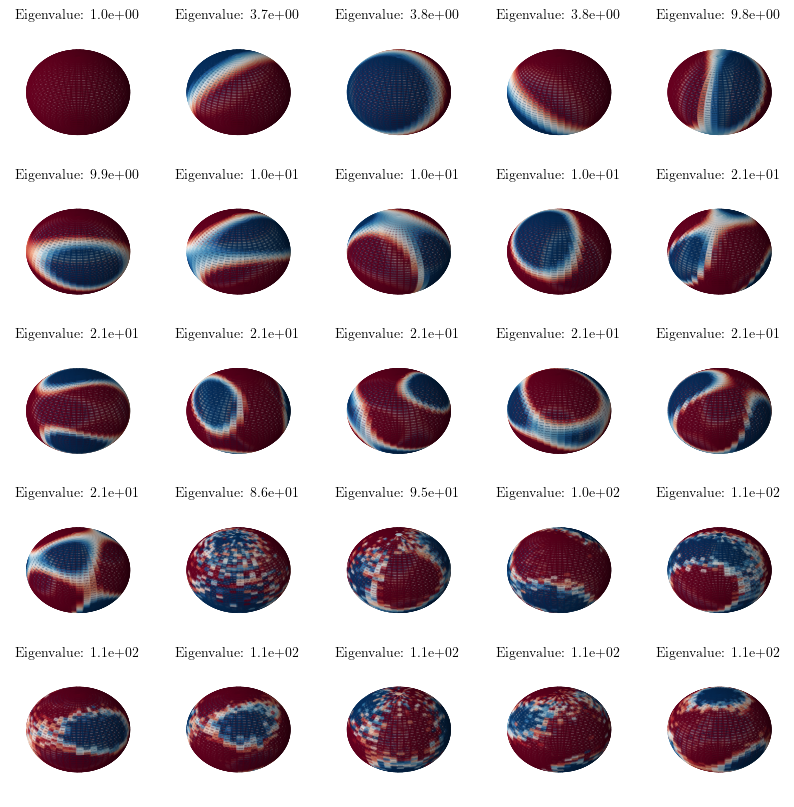

In [12]:
fig, axes = plt.subplots(num, num, figsize=(10, 10), subplot_kw={"projection": "3d"})
for i in range(num ** 2):
    plot_sphere_surface(axes[i//num, i%num], X, Y, Z, phi[:, i], alpha=.5)
    axes[i//num, i%num].set_title(f"Eigenvalue: {kernel.eigenvalues[i]:.1e}", fontsize=10)

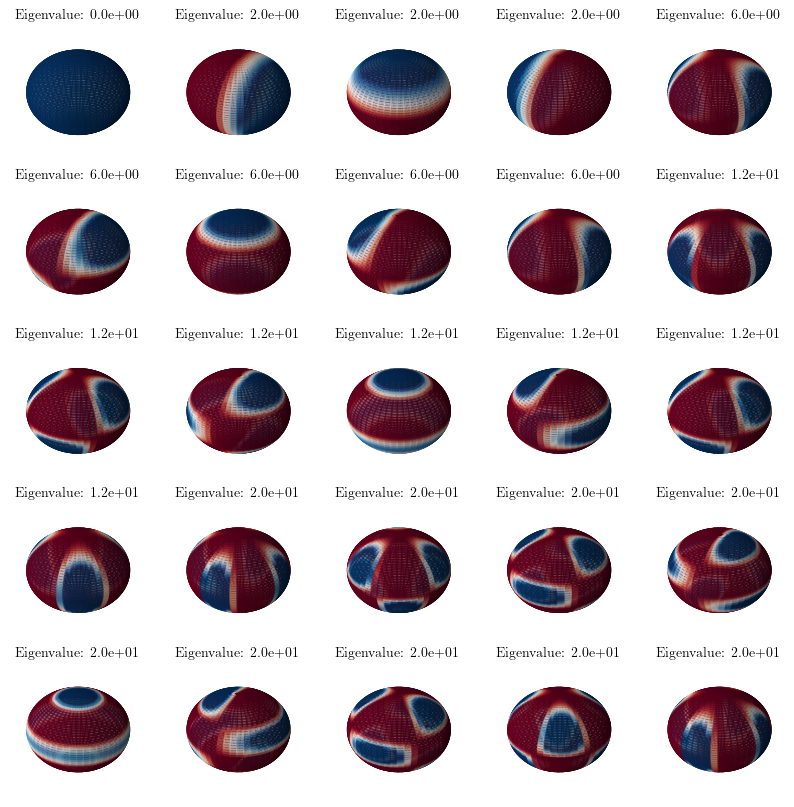

In [13]:
fig, axes = plt.subplots(num, num, figsize=(10, 10), subplot_kw={"projection": "3d"})
for i in range(num ** 2):
    plot_sphere_surface(axes[i//num, i%num], X, Y, Z, phi_true[:, i], alpha=.5)
    axes[i//num, i%num].set_title(f"Eigenvalue: {eigenvalues[i]:.1e}", fontsize=10)